En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_mt as rrnn
import multitask_dep as mt

import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']
encoding_type = 'relative'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [6]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# MultiTask SGD

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [13]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_sgd_relative'

In [14]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4898989898989899, 'as': 0.48370273794002605, 'about': 0.4872448979591837}
Accuracy evaluando en etiquetas female
{'to': 0.7847769028871391, 'as': 0.7951482479784366, 'about': 0.7575}
Accuracy evaluando en etiquetas male
{'to': 0.21654501216545013, 'as': 0.1919191919191919, 'about': 0.20572916666666666}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.078428089411001 	 Validation loss: 2.080163834458691 	 
  1%|          | 574/57400 [00:06<09:46, 96.88it/s]
Epoch 2 	 Training loss: 2.076493870505888 	 Validation loss: 2.081261331752195 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:03, 93.16it/s]
Epoch 3 	 Training loss: 2.0759703622877805 	 Validation loss: 2.0820649599624894 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:32, 97.17it/s]
Epoch 4 	 Training loss: 2.0763506665047036 	 Validation loss: 2.0803861860501565 	 
  4%|▍         | 2296/57400 [00:26<09:24, 97.65it/s]
Epoch 5 	 Training loss: 2.076000391813936 	 Validation loss: 2.0814981056472 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:25, 96.37it/s]
Epoch 6 	 Training loss: 2.0761704760561424 	 Validation loss: 2.0826487702838445 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:07, 98.62it/s]
Epoch 7 	 Training loss: 2.0758562420303397 	 Validation loss: 2.

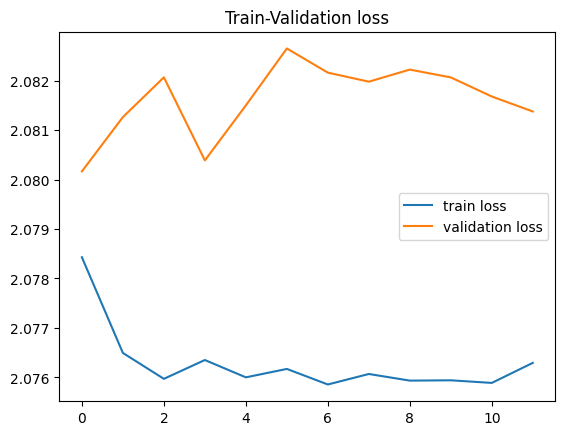

In [15]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5227272727272727, 'as': 0.5189048239895697, 'about': 0.49107142857142855}
Accuracy evaluando en etiquetas female
{'to': 0.010498687664041995, 'as': 0.01078167115902965, 'about': 0.0025}
Accuracy evaluando en etiquetas male
{'to': 0.9975669099756691, 'as': 0.9949494949494949, 'about': 1.0}


# AdamW

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_adamw_relative'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075622198473701 	 Validation loss: 2.0791774765919833 	 
  1%|          | 574/57400 [00:06<10:35, 89.37it/s]
Epoch 2 	 Training loss: 2.074046771285426 	 Validation loss: 2.0781575744434937 	 
  2%|▏         | 1148/57400 [00:13<10:35, 88.56it/s]
Epoch 3 	 Training loss: 2.0705523636282943 	 Validation loss: 2.074967655084901 	 
  3%|▎         | 1722/57400 [00:20<10:36, 87.51it/s]
Epoch 4 	 Training loss: 2.0667932984720956 	 Validation loss: 2.0708855774443027 	 
  4%|▍         | 2296/57400 [00:28<10:26, 87.89it/s]
Epoch 5 	 Training loss: 2.0647309885623146 	 Validation loss: 2.067056554858967 	 
  5%|▌         | 2870/57400 [00:35<10:13, 88.86it/s]
Epoch 6 	 Training loss: 2.064842998773794 	 Validation loss: 2.0690536822302867 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:42<10:08, 88.65it/s]
Epoch 7 	 Training loss: 2.0623560628824533 	 Validation loss: 2.066162529638258 	 
  7%|▋         | 4018/57400 [00:49<09:53, 89.88it/s]
Epoch 8 	 Tr

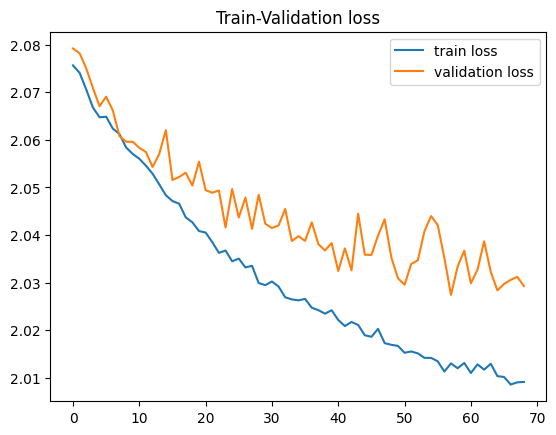

In [18]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [19]:
model =  rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5921717171717171, 'as': 0.6010430247718384, 'about': 0.6556122448979592}
Accuracy evaluando en etiquetas female
{'to': 0.49868766404199477, 'as': 0.5822102425876011, 'about': 0.5825}
Accuracy evaluando en etiquetas male
{'to': 0.6788321167883211, 'as': 0.6186868686868687, 'about': 0.7317708333333334}
